# Rofous Dev
This file is where you can test and develop controls for the rofous project

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Aerial_Device import Aerial_Device, Renderer
from Transformer import Transformer
%matplotlib notebook

# Testing

In [242]:
# load the data from the LSM6Ds3
still = pd.read_csv('../data/Stationary-Test.csv')
drop = pd.read_csv('../data/Drop-Test.csv')
toss = pd.read_csv('../data/Toss-Test.csv')
toss.tail()

,Time,Xaccel,Yaccel,Zaccel,Xvel,Yvel,Zvel,PHIvel,THETAvel,PSIvel,X,Y,Z,PHI,THETA,PSI
250,3009.0,-0.21,0.14,1.01,-0.08,-0.34,0.5018.49,1.89,2.08,-0.61,0.77,0.260.26,3.03,2.8,NaN,NaN
251,3020.0,-0.21,0.15,1.01,-0.08,-0.34,0.5123.50,0.98,2.01,-0.61,0.77,0.260.26,3.03,2.8,NaN,NaN
252,3033.0,-0.19,0.17,0.99,-0.08,-0.34,0.5128.38,-0.06,2.26,-0.62,0.78,0.270.27,3.03,2.8,NaN,NaN
253,3044.0,-0.18,0.19,0.98,-0.08,-0.34,0.5131.01,0.43,2.26,-0.62,0.79,0.270.27,3.03,2.8,NaN,NaN
254,3057.0,-0.19,0.19,0.97,-0.08,-0.34,0.5126.79,4.03,1.46,-0.63,0.79,0.280.28,3.03,2.8,NaN,NaN


In [243]:
def show_test(test, label, axes):
    axes[0][0].plot(test.Time, test.Xaccel, c='r', label='accel')
    axes[0][0].plot(test.Time, test.Xvel, c='g', label='Vel')
    axes[0][0].plot(test.Time, test.X, c='b', label='X')
    axes[0][0].set_title(f'{label} - X')
    
    axes[0][1].plot(test.Time, test.Xodac, c='r', label='accel')
    axes[0][1].plot(test.Time, test.Xodvel, c='g', label='Vel')
    axes[0][1].plot(test.Time, test.Xodom, c='b', label='X')
    axes[0][1].set_title(f'{label} - X odom')
    
    axes[1][0].plot(test.Time, test.Yaccel, c='r', label='accel')
    axes[1][0].plot(test.Time, test.Yvel, c='g', label='vel')
    axes[1][0].plot(test.Time, test.Y, c='b', label='Y')
    axes[1][0].set_title(f'{label} - Y')
    
    axes[1][1].plot(test.Time, test.Yodac, c='r', label='accel')
    axes[1][1].plot(test.Time, test.Yodvel, c='g', label='vel')
    axes[1][1].plot(test.Time, test.Yodom, c='b', label='Y')
    axes[1][1].set_title(f'{label} - Y odom')
    
    axes[2][0].plot(test.Time, test.Zaccel, c='r', label='accel')
    axes[2][0].plot(test.Time, test.Zvel, c='g', label='vel')
    axes[2][0].plot(test.Time, test.Z, c='b', label='Z')
    axes[2][0].set_title(f'{label} - Z')
    
    axes[2][1].plot(test.Time, test.Zodac, c='r', label='accel')
    axes[2][1].plot(test.Time, test.Zodvel, c='g', label='vel')
    axes[2][1].plot(test.Time, test.Zodom, c='b', label='Z')
    axes[2][1].set_title(f'{label} - Z odom')

    return axes


In [272]:
def df_odometry(df):
    pose = np.zeros((1,3))
    vel = np.zeros((1,3))
    a = np.zeros((1,3))
    t_ = 0.0
    theta = 0.0
    phi = 0.0
    tf = Transformer(0.0, 0.0, 0.0, pose)
    for i, row in df.iterrows():
        t = (row.Time - t_) / 1000.0
        t_ = row.Time
        
        acc = np.array([row.Xaccel, -row.Yaccel, -row.Zaccel], dtype=np.float) # Gs assume motor thrust is removed
        acc =  (acc * 9.81) / np.linalg.norm(acc)
        
        theta = np.arctan(acc[0] / np.sqrt(acc[1]**2 + acc[2]**2))
        phi = np.arctan(acc[1] / np.sqrt(acc[0]**2 + acc[2]**2))
        tf.build_transform(phi, theta, 0, pose[0])
        
        acc = tf.transform(acc, inverse=True)
        pose = np.concatenate([pose, [pose[-1] + (vel[-1] * t)]])
        vel = np.concatenate([vel, [vel[-1] + ((acc - (0.0,0.0,9.81)) * t)]]) # note that the still test will have a negative z force
        a = np.concatenate([a, [acc]])
        
    df['Xodac'] = a[1:,0]
    df['Yodac'] = a[1:,1]
    df['Zodac'] = a[1:,2]
    df['Xodvel'] = vel[1:,0]
    df['Yodvel'] = vel[1:,1]
    df['Zodvel'] = vel[1:,2]
    df['Xodom'] = pose[1:,0]
    df['Yodom'] = pose[1:,1]
    df['Zodom'] = pose[1:,2]
    return df

<IPython.core.display.Javascript object>


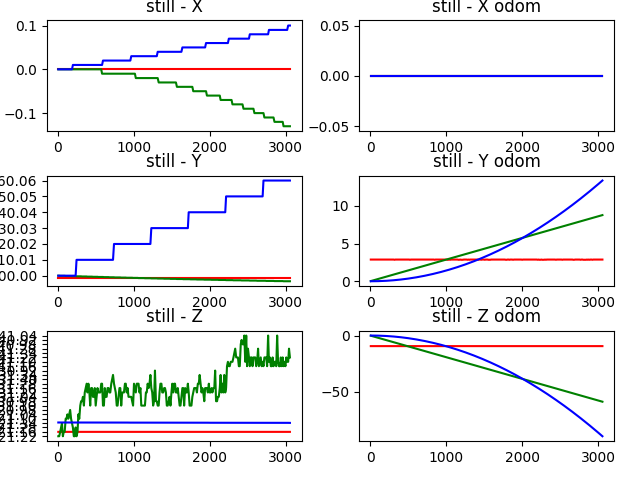

In [273]:
still_processed = df_odometry(still)
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
still.tail()
axes = show_test(still_processed, 'still', axes)
plt.show()

<IPython.core.display.Javascript object>


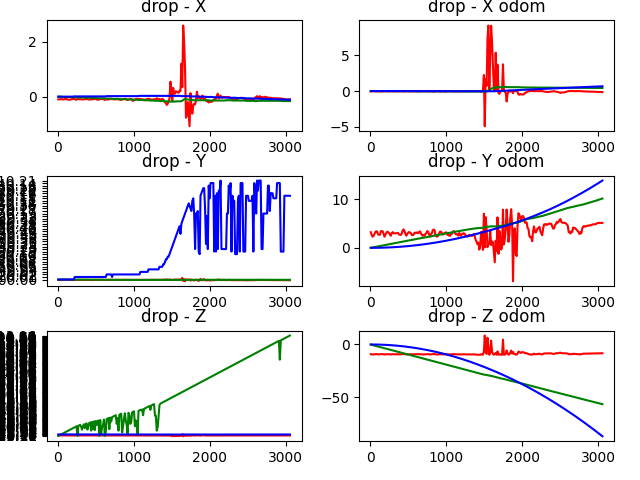

In [274]:
drop_processed = df_odometry(drop)
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes = show_test(drop_processed, 'drop', axes)
plt.show()

<IPython.core.display.Javascript object>


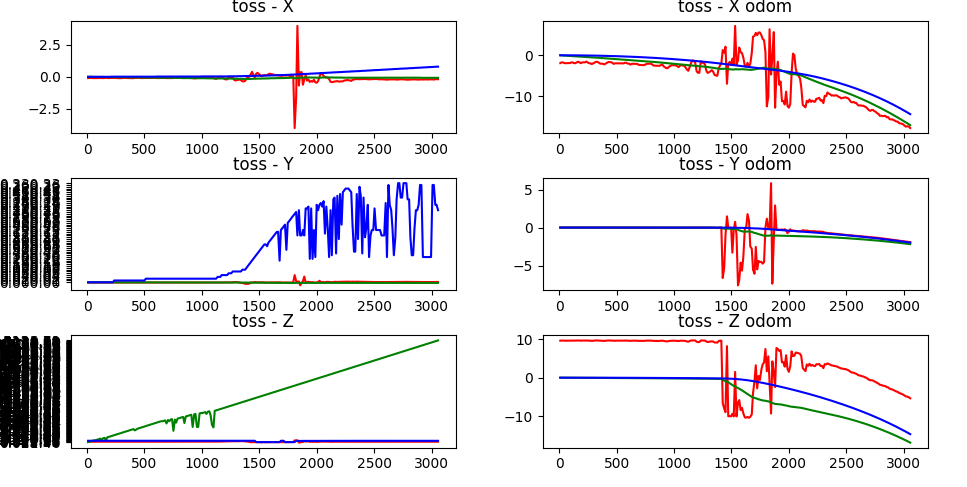

In [269]:
toss_processed = df_odometry(toss)
fig, axes = plt.subplots(3, 2)
fig.tight_layout()
axes = show_test(toss_processed, 'toss', axes)
plt.show()

In [2]:
class PID:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.p = 0.0
        self.i = 0.0
        
    def converge(self, e):
        if np.sign(e) != np.sign(self.p):
            self.i = 0.0
        
        d = self.p - e
        self.i += e
        self.p = e
        return (self.kp * self.p) + (self.i * self.ki) + (d * self.kd)

# Attitude Contrtol
The issue of stabilizing a quadcopter is difficult because of the non-linearity of the controls and motion. Initial I was inspired by a paper to use cascade PID although have not yet implemented it. The simulation I built is messy and hard to follow, instead maybe its time to go into hardware mode.

Pose:
	[0. 0. 0.]
	[-0.26179939  0.26179939  0.        ]
Throttle:
	[0. 0. 0. 0.]


<IPython.core.display.Javascript object>


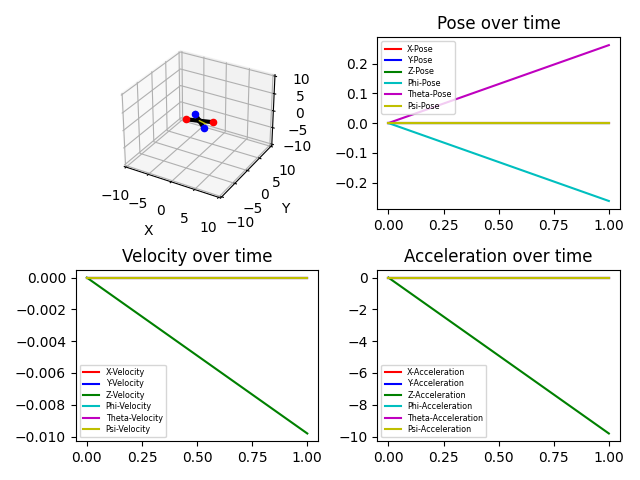

In [114]:
kp = 1.02
ki = 0.0
kd = 2.02
rofous = Aerial_Device(np.array([[2,2,0],[2,-2,0],[-2,-2,0],[-2,2,0]]),
                   np.array([[0.0,0.0,3*np.pi/4],[0.0,0.0,np.pi/4],[0.0,0.0,-np.pi/4],[0.0,0.0,-3*np.pi/4]]),
                   np.array([-1, 1, -1, 1]), 150, 5, -0.05, 0.9)
mControls = [PID(kp,ki,kd), PID(kp,ki,kd)]#[PID(kp, ki, kd),PID(kp, ki, kd),PID(kp, ki, kd),PID(kp, ki, kd)]
throttles = np.zeros(rofous.nMotors)
artist = Renderer(rofous)
rofous.reset()
rofous.refActual = np.array([-np.pi/12,np.pi/12,0.0])
dE = [0.0,0.0,0.0,0.0]

for i in range(1):
    rofous.update_odometry(t=0.001)
    rofous.poseActual = np.array([0.0,0.0,0.0])
    #for i in range(rofous.nMotors):
    motor_pose0 = rofous.autobots[1].transform(np.array([0.0,0.0,0.0]), inverse=True)
    motor_pose1 = rofous.autobots[2].transform(np.array([0.0,0.0,0.0]), inverse=True)
    
    throttles[0] = mControls[0].converge(rofous.poseActual[2] - motor_pose0[2])
    throttles[1] = mControls[1].converge(rofous.poseActual[2] - motor_pose1[2])
    throttles[2] = -mControls[0].converge(rofous.poseActual[2] - motor_pose0[2])
    throttles[3] = -mControls[1].converge(rofous.poseActual[2] - motor_pose1[2])
    rofous.adjust_throttle(throttles)
    
    if np.abs(np.sum(rofous.path['Pose'][-5:])) < 1e-3:
        break
        
print(f'Pose:\n\t{rofous.poseActual}\n\t{rofous.refActual}')
print(f'Throttle:\n\t{rofous.throttleActual}')
artist.render()

Pose:
	[0.00169207 0.00161671 0.00448081]
	[-0.23350285  0.21693198 -0.02475071]
Throttle:
	[100.           0.           0.           3.37136809]


<IPython.core.display.Javascript object>


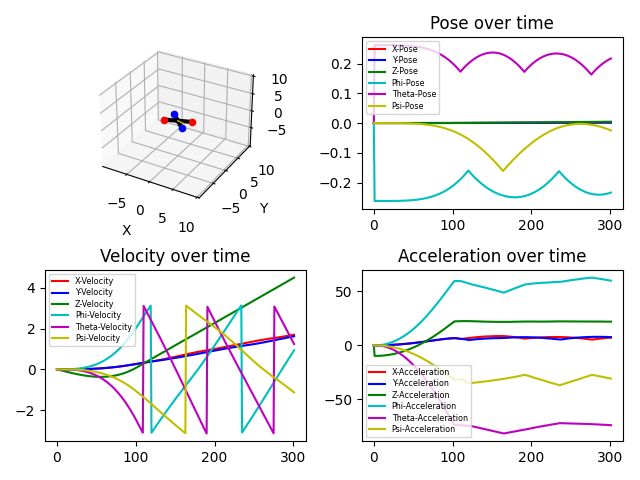

In [117]:
for i in range(100):
    rofous.poseActual = np.array([0.0,0.0,0.0])
    rofous.update_odometry(t=0.001)
    #for i in range(rofous.nMotors):
    
    motor_pose0 = rofous.autobots[1].transform(np.array([0.0,0.0,0.0]), inverse=True)
    motor_pose1 = rofous.autobots[2].transform(np.array([0.0,0.0,0.0]), inverse=True)
    throttles[0] = mControls[0].converge(rofous.poseActual[2] - motor_pose0[2])
    throttles[1] = mControls[1].converge(rofous.poseActual[2] - motor_pose1[2])
    throttles[2] = -mControls[0].converge(rofous.poseActual[2] - motor_pose0[2])
    throttles[3] = -mControls[1].converge(rofous.poseActual[2] - motor_pose1[2])
    rofous.adjust_throttle(throttles)
    if np.abs(np.sum(rofous.path['Pose'][-5:])) < 1e-5:
        break
        
print(f'Pose:\n\t{rofous.poseActual}\n\t{rofous.refActual}')
print(f'Throttle:\n\t{rofous.throttleActual}')
artist.render()

# Altitude Control

In [14]:
kp = 1.2
ki = 0.0
kd = 2
rofous = Aerial_Device(np.array([[2,2,0],[2,-2,0],[-2,-2,0],[-2,2,0]]),
                   np.array([[0.0,0.0,3*np.pi/4],[0.0,0.0,np.pi/4],[0.0,0.0,-np.pi/4],[0.0,0.0,-3*np.pi/4]]),
                   np.array([-1, 1, -1, 1]), 150, 5, -0.05)
pid = PID(kp, ki, kd)
throttles = np.zeros(rofous.nMotors)
artist = Renderer(rofous)
rofous.reset()
target = 10

for i in range(500):
    rofous.update_odometry()
    throttles = [pid.converge(target - rofous.poseActual[2])] * rofous.nMotors
    rofous.adjust_throttle(throttles)
    if np.abs(np.sum(rofous.path['Pose'][-5:])) < 1e-3:
        break
        
print(f'Pose:\n\t{rofous.poseActual}\n\t{rofous.refActual}')
print(f'Throttle:\n\t{rofous.throttleActual}')
artist.render()

TypeError: __init__() missing 1 required positional argument: 'vel_decay'